In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

In [38]:
class StochasticSIR():
    def __init__(self, inits, params, t0=0):
        
        self.gam, self.beta, self.mu, self.eta = params # initialize parameters
        self.inits = inits                              # initial conditions
        
        self.R0 = self.beta/(self.gam + self.mu) # R-number
        
        self.model = [inits] # for storing population counts at each time step
        self.time = [t0]     # time list
        self.extincts = []   # list for storing when extictions happen
        
    def get_event(self, pops):
        """ Get which event happens next given pops=(X, Y, Z)"""
        X, Y, Z = pops
        N = sum(pops)
        
        # compute rates
        birthrate = self.mu*N
        transrate = self.beta*X*Y/N
        recorate  = self.gam*Y
        deathX    = self.mu*X
        deathY    = self.mu*Y
        deathZ    = self.mu*Z
        importrate = self.eta*np.sqrt(N) 
        
        rates = np.array([birthrate, transrate, recorate, deathX, deathY, deathZ, importrate])
        dt = -np.log(np.random.random())/np.sum(rates) # time step
        P = np.random.random()*np.sum(rates)           # random number
        E = np.min(np.where(np.cumsum(rates) >= P))    # next event: whichever event has a larger cumulative sum than P
        
        return E, dt
    
    def update(self, event, pops):
        """ Update the population counts given the event """
        
        X, Y, Z = pops
        if event == 0:   # birth
            X += 1
        elif event == 1: # transmission
            X -= 1
            Y += 1
        elif event == 2: # recovery
            Y -= 1
            Z += 1
        elif event == 3: # death in susceptible
            X -= 1
        elif event == 4: # death in infected
            Y -= 1
        elif event == 5: # death in recovered
            Z -= 1
        elif event == 6: # import of infected
            Y += 1
            X -= 1
            
        return [X, Y, Z]
    
    def simulate(self, maxT):
        """ Simulate the model to maxT time"""
        
        # set initial simulation values
        pops = self.model[-1]
        t = self.time[-1]
        while t < maxT: 
            if self.model[-1][1] <= 0: # check disease extinction
                self.extincts.append(t)
                
            event, dt = self.get_event(pops) # get event and time step
            
            pops = self.update(event, pops) # update population
            t += dt                         # update time
            
            self.model.append(pops) # append population to list
            self.time.append(t)     # append time to list

    def burn_in(self, T):
        """ Burn in model for T time, set end values to future initial values,
            and reset extinctions."""
        self.simulate(T)
        self.model = [self.model[-1]]
        self.time = [self.time[-1]]
        self.extincts = []
        
            
    def unpack(self):
        """ Get X, Y, Z as as a numpy matrix """
        
        XYZ = np.zeros((len(self.time), 3))
        for i in range(len(XYZ)):
            XYZ[i, 0] = self.model[i][0]
            XYZ[i, 1] = self.model[i][1]
            XYZ[i, 2] = self.model[i][2]
        
        return XYZ
    
    def get_end_equilibrium(self):
        """ Get endemic equilibrium values """
        R0 = self.beta/(self.mu + self.gam)
        N = sum(self.model[0])
        
        S_eq = 1.0/R0
        I_eq = self.mu/self.beta*(R0 - 1)
        R_eq = 1.0 - S_eq - I_eq
        
        return (S_eq*N, I_eq*N, R_eq*N)
    
    def reset(self):
        """ Reset the model """
        self.model = [self.inits]
        self.time = [self.time[0]]
        self.extincts = []
        
    def solve_deterministic(self, func, tspan, inits=None):
        """ Solve the given deterministic SIR func model """
        p = (self.gam, self.beta, self.mu)
        
        if inits is not None:
            u0 = inits
        else:
            u0 = np.array(self.inits) / sum(self.inits)
            
        
        sol = solve_ivp(func, tspan, u0, args=p, dense_output=True)
        
        return sol
    
    def plot(self, tspan=None, var=None, **kwargs):
        """ 
        Plot variables over timespan tspan. Default all 
        compartments over whole time interval.
        """
        
        time = np.array(model.time)
        idxs = np.arange(len(time))
        
        if tspan is not None:
            idxs = np.where((time >= tspan[0]) & (time <= tspan[1]))[0]
            time = time[idxs]
            
        sol = model.unpack()
        if var is not None:
            tempsol = sol[idxs,:]
            sol = tempsol[:,var]
        else:
            sol = sol[idxs,:]
            
        plt.plot(time, sol, **kwargs)


# 1: Variability

     Variability between simulations. The most obvious element of any stochastic model
    is that different simulations give rise to different outcomes. This implies that although
    the general statistical properties (such as the mean and the variance) may be
    accurately predicted, it is generally impossible to predetermine the precise disease
    prevalence at any given point in the future.

In [202]:
# initial conditions
N = 100
Y0 = 1
X0 = N - Y0
Z0 = 0

inits = [X0, Y0, Z0]

# parameter values
mu = 1/75
gam = 1.0
beta = 3.0
eta = 0.02

params = [gam, beta, mu, eta]

# initialize model
model = StochasticSIR(inits, params)

In [203]:
# perform 100 interations and save end values
N_iters = 100

end_vals = np.zeros((N_iters, 3))
for i in range(N_iters):
    model.simulate(100)
    end_vals[i,:] = model.model[-1]
    model.reset()

In [211]:
means = np.mean(end_vals, axis=0) # compute mean values

[29.34  1.03 68.37]


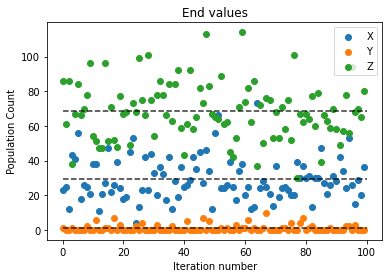

In [223]:
plt.scatter(range(0, N_iters), end_vals[:,0])
plt.scatter(range(0, N_iters), end_vals[:,1])
plt.scatter(range(0, N_iters), end_vals[:,2])
plt.hlines(means, 0, N_iters, alpha=0.8, linestyle="--", color="black")
plt.legend(["X", "Y", "Z"])
plt.xlabel("Iteration number")
plt.ylabel("Population Count")
plt.title("End values")
plt.savefig("figures/endvals.svg")
print(means)

# 2: Negative co-variances

    Variances and covariances. The continual perturbations caused by the random nature
    of stochastic equations leads to variation in the prevalence of disease and the number
    of susceptibles. Additionally, the interaction between stochasticity and deterministic
    dynamics generally causes negative covariance between the numbers of infectious
    and susceptible individuals, which in turn can cause the mean population levels
    (X, Y) to deviate from the deterministic equilibria.

In [142]:
Ns = np.arange(50, 1050, 50) # total population values
mu = 1/75
gam = 0.7
beta = 3.0
eta = 0.02

params = [gam, beta, mu, eta]

cov = np.zeros((len(Ns), 2, 2))
for (i, N) in enumerate(Ns):
    Y0 = 1
    X0 = N - Y0
    Z0 = 0

    inits = [X0, Y0, Z0]
    model = StochasticSIR(inits, params)
    
    # perform 20 iteration to get the mean
    for k in range(20):
        model.burn_in(50) # burn in for 50 time units
        model.simulate(250) # simulate for 200 time units
        sol = model.unpack()

        cov_ = np.cov(sol[:,0], sol[:,1]) # compute covariance
        #print(cov_[0,1])
        cov[i,:,:] += cov_
        model.__init__(inits, params)
        
    cov[i,:,:] /= 20
    
    print(f"{i+1} of {len(Ns)} done")

1 of 20 done
2 of 20 done
3 of 20 done
4 of 20 done
5 of 20 done
6 of 20 done
7 of 20 done
8 of 20 done
9 of 20 done
10 of 20 done
11 of 20 done
12 of 20 done
13 of 20 done
14 of 20 done
15 of 20 done
16 of 20 done
17 of 20 done
18 of 20 done
19 of 20 done
20 of 20 done


Text(0, 0.5, 'Covariance')

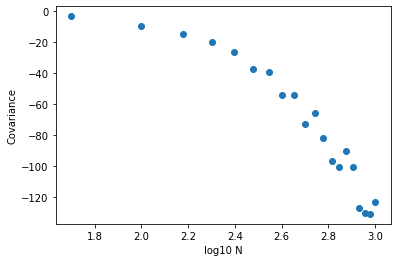

In [147]:
plt.scatter(np.log10(Ns), cov[:,0,1])
plt.xlabel("log10 N")
plt.ylabel("Covariance")
plt.savefig("figures/covariance.svg")

## Variance

In [177]:
Ns = np.logspace(1, 4, 10) # total population values
mu = 1/75
gam = 1.0
beta = 3.0
eta = 0.02

params = [gam, beta, mu, eta]

model = StochasticSIR(np.zeros(3), params)
var = np.zeros((len(Ns)))   # for storing mean variance
meanY = np.zeros((len(Ns))) # for storing mean Y values

for (i, N) in enumerate(Ns):
    Y0 = 1
    X0 = N - Y0
    Z0 = 0

    model.__init__(inits, params)
    
    inits = [X0, Y0, Z0]
    for k in range(20):
        model.burn_in(25)
        model.simulate(225)
        sol = model.unpack()

        var[i] += np.var(sol[:,1])
        meanY[i] += np.mean(sol[:,1])
        model.reset()
    
    var[i] /= 20
    meanY[i] /= 20


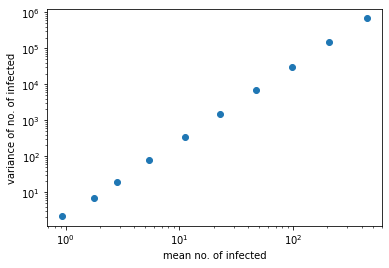

In [180]:
plt.scatter(meanY, var)
plt.yscale("log")
plt.xscale("log")
plt.xlabel("mean no. of infected")
plt.ylabel("variance of no. of infected")
plt.savefig("figures/variance.svg")

# 3: Increased Transients

    Increased transients. Stochastic perturbations away from the equilibrium solution
    are countered by the generally convergent behavior of the underlying deterministic
    dynamics. When far from the endemic equilibrium point, these restorative forces
    are usually strong and dominate, so that the model acts much like the deterministice 
    quations. Thus, the dynamics of stochastic models can be conceptualized as
    resulting from random perturbations away from, and transient-like return toward, the
    deterministic attractor
    
    
I.e.: when far from the equilibrium, we will get sharper jumps back towards the equilibrium

In [ ]:
def SIR(t, u, gam, beta, mu):
    """ Deterministic SIR model"""
    S, I, R = u
    
    dS = mu - mu*S - beta*S*I
    dI = beta*S*I - mu*I - gam*I
    dR = gam*I - mu*R
    
    return [dS, dI, dR]

In [60]:
N = 150

mu = 1/75
gam = 0.1
beta = 3.0
eta = 0#0.02

params = [gam, beta, mu, eta]


Ys = []
time = []
det = []

Y0 = 100
X0 = N - Y0
Z0 = 0

inits = [X0, Y0, Z0]

model = StochasticSIR(inits, params)

# perform 10 simulations
for i in range(10):
    
    model.simulate(300)
    
    sol = model.unpack()
    Ys.append(sol[:,1])
    time.append(model.time)
    
    model.reset()
    
# solve deterministic model
sol = model.solve_deterministic(SIR, (0, 300))
det.append(sol.sol(time[0])[1,:]) # interpolate

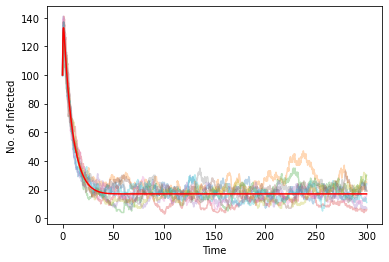

In [68]:
 for i in range(10):
    plt.plot(time[i], Ys[i], alpha=0.3)
plt.plot(time[0], det[0]*N, color="red")
plt.ylabel("No. of Infected")
plt.xlabel("Time")
plt.savefig("figures/transients.svg")

# 4: Stochastic Resonance


    Stochastic resonance. As most SIR-type disease models approach equilibrium in
    a series of decaying epidemics, the increased transient-like dynamics of stochastic
    models leads to oscillations close to the natural frequency (Chapter 2). Thus,
    stochasticity can excite epidemic oscillations around the normal endemic prevalence,
    leading to sustained cycles.


In [14]:
N = 150

mu = 1/8
gam = 0.1
beta = 1.0
eta = 0#0.02

params = [gam, beta, mu, eta]


Ys = []
time = []
det = []

Y0 = 10
X0 = N - Y0
Z0 = 50

inits = [X0, Y0, Z0]

model = StochasticSIR(inits, params)


for i in range(10):
    model.simulate(100)

    I = model.unpack()[:,1]
    Ys.append(I)
    time.append(model.time)
    model.reset()

sol = model.solve_deterministic(SIR, (0, 100))
sol = sol.sol(time[-1])[1,:]


In [22]:
# for computing the mean: interpolate over one time array to get
# all the Y arrays to be the same size 
Yys = np.array([np.interp(time[-1], time[i], Y) for (i, Y) in enumerate(Ys)]) 

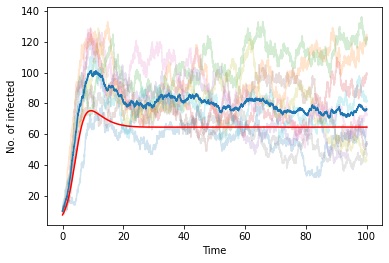

In [38]:
for i in range(10):
    plt.plot(time[i], Ys[i], alpha=0.2)
plt.plot(time[-1], sol*N, color="red")
plt.plot(time[-1], np.mean(Yys, axis=0))
plt.xlabel("Time")
plt.ylabel("No. of infected")
plt.savefig("figures/stochastic_resonance.svg")

# 5: Extinctions

## 5.1: Average no. of extinctions per year

    A more mathematically pleasing approach is to start the stochastic
    simulations at, or near to, the deterministic equilibrium and measure the average
    time until the population goes extinct—called the “first passage time.” 

In [14]:
N_iters = 25

Ns = np.logspace(1, 5, 20)

mu = 1/50
gam = 0.7
beta = 10.0
eta = 0.02

params = [gam, beta, mu, eta]

extcs = np.zeros(len(Ns))
for (i, N) in enumerate(Ns):
    Y0 = 1
    X0 = N - Y0
    Z0 = 0
    inits = [X0, Y0, Z0]
    model = StochasticSIR(inits, params)
    for j in range(N_iters):
        model.burn_in(10)
        model.simulate(210)

        
        extcs[i] += len(model.extincts)
        model.reset()
        
    
    extcs[i] /= N_iters
    
np.save("excts", extcs)

KeyboardInterrupt: 

In [98]:
extcs = np.load("excts.npy")
Ns = np.logspace(1, 5, 20)

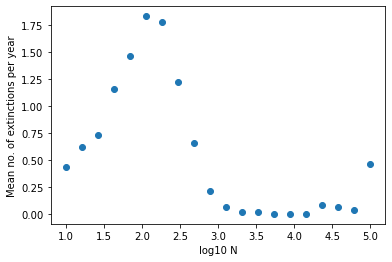

In [101]:
plt.scatter(np.log10(Ns), extcs/200)
plt.xlabel("log10 N")
plt.ylabel("Mean no. of extinctions per year")
plt.savefig("figures/extcs_per_year.svg")

## 5.2: First Passage Time

In [175]:
N_iters = 20

Ns = np.logspace(2, 4, 20)

mu = 1/50
gam = 1.0
beta = 3.0
eta = 0.02

params = [gam, beta, mu, eta]

t_exct = np.zeros(len(Ns))
for (i, N) in enumerate(Ns):
    Y0 = 1
    X0 = N - Y0
    Z0 = 0
    inits = [X0, Y0, Z0]
    
    model = StochasticSIR(inits, params)
    ctr = 1 # for computing the mean
    for j in range(N_iters):
        model.burn_in(50)
        model.simulate(200)

        if len(model.extincts) > 1:   # if there are extinctions
            t_exct[i] += model.extincts[0] # get first time of extinction
            ctr += 1
        
        model.__init__(inits, params)
        
    t_exct[i] /= ctr
    print(f"{i+1} of {len(Ns)} done")

1 of 20 done
2 of 20 done
3 of 20 done
4 of 20 done
5 of 20 done
6 of 20 done
7 of 20 done
8 of 20 done
9 of 20 done
10 of 20 done
11 of 20 done
12 of 20 done
13 of 20 done
14 of 20 done
15 of 20 done
16 of 20 done
17 of 20 done
18 of 20 done
19 of 20 done
20 of 20 done


In [183]:
np.save("first_passage", t_exct)

<ipython-input-191-d9ffb93a300d>:2: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(np.log10(Ns), np.log10(t_exct))


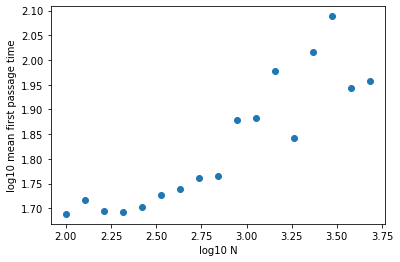

In [191]:
Ns = np.logspace(2, 4, 20)
plt.scatter(np.log10(Ns), np.log10(t_exct))
plt.xlabel("log10 N")
plt.ylabel("log10 mean first passage time")
plt.savefig("figures/first_passage.svg")

# Part 2: Metapopulation Models

In [66]:
class StochasticMetaSIR():
    def __init__(self, inits, gamma, beta, rho):
        self.n_pops = len(inits)
        self.beta = beta     # list/array
        self.gamma = gamma
        self.rho = rho
        
        self.model = np.zeros((self.n_pops, 3))
        for i in range(self.n_pops):
            self.model[i, :] = inits[i]
            
        self.time = []
            
        self.pops = [[(self.model[i,0], self.model[i,1], self.model[i,2])] for i in range(self.n_pops)]
        
    def get_event(self):
        
        rates = np.zeros((self.n_pops, 3)) # 3 possible events for each subpop
        for i in range(self.n_pops):
            X, Y, Z = self.model[i,:]
            N = sum(self.model[i,:])
            
            rates[i, 0] = self.beta[i]*X*Y/N        # internal transmission
            rates[i, 1] = self._lambda(i)*X         # transmission from other population
            rates[i, 2] = self.gamma[i]*Y           # recovery
            
        dt = -np.log(np.random.random())/np.sum(rates) # time step
        P = np.random.random()*np.sum(rates)           # random number
        E = np.min(np.where(np.cumsum(rates) >= P))    # event
                
        return E+1, dt   
    
    def _lambda(self, i):
        """ Rate of infection from other populations """
        N = np.sum(self.model[i,:])
        return self.beta[i]/N*np.sum(rho[i,:]*self.model[:,1])
    

    def update(self, event):
        
        pop_id = int(np.ceil((event)/3)) # population whose event happens
        pop_id -= 1
        
        events = np.arange(1, 3*self.n_pops+1)  # all possible event
        events = events[pop_id*3:pop_id*3 + 3]  # all possible events for this population
        
        which_event = np.where(event == events)[0] # which of these events happen
        
        if which_event == 0:   # internal transmission
            self.model[pop_id, 0] -= 1
            self.model[pop_id, 1] += 1
        elif which_event == 1: # transmission from other population
            self.model[pop_id, 0] -= 1
            self.model[pop_id, 1] += 1
        elif which_event == 2:              # recovery            
            self.model[pop_id, 1] -= 1
            self.model[pop_id, 2] += 1
            
    def simulate(self, T):
        """ Simulate for T seconds """
        
        t = 0
        self.time.append(t)
        while t <= T:
            if np.all(self.model[:,1] <= 0):
                break
                
            event, dt = self.get_event()
            self.update(event)
            
            for i in range(self.n_pops):
                self.pops[i].append(tuple(self.model[i,:]))
            t += dt
            self.time.append(t)
            
    def unpack(self):
        """
        Unpack populations into arrays.
        First index is population id, second index
        is time step, third index is compartment (X/Y/Z)
        """
        
        n_pts = len(self.time)
        pop_array = np.zeros((self.n_pops, n_pts, 3))
        
        for i in range(n_pts):
            for p in range(self.n_pops):
                pop_array[p,i,:] = self.pops[p][i]

        return pop_array
        

## 2.1: Two subpopulations

In [101]:
inits = [[100, 0, 0], [99, 1, 0]]
gamma = [1.0, 1.0]
beta = [3.0, 3.0]

rhos = np.array([0.2, 0.9, 0.2, 0.9]).reshape(2, 2)
model = StochasticMetaSIR(inits, gamma, beta, rho)

In [109]:
# perform 20 simulations

mean_pop_1 = []
mean_pop_2 = []

time = np.linspace(0, 6, 1000)
Y1_mean = np.zeros((2, 2, len(time)))
Y2_mean = np.zeros((2, 2, len(time)))
for i in range(2):
    for j in range(2):
        rho = np.array([1.0, rhos[i, j], rhos[j, i], 1]).reshape(2, 2)
        model = StochasticMetaSIR(inits, gamma, beta, rho)
        
        ctr = 1
        for k in range(100):
            model.simulate(10)
            if model.time[-1] > 5:
                sol = model.unpack()
                Y1 = sol[0,:,1]
                Y2 = sol[1,:,1]
                
                # interpolate to get all iterations the same length
                Y1_mean[i, j, :] += np.interp(time, model.time, Y1)
                Y2_mean[i, j, :] += np.interp(time, model.time, Y2)
                
                ctr += 1
                
            model.__init__(inits, gamma, beta, rho)
            
        Y1_mean[i, j, :] /= ctr
        Y2_mean[i, j, :] /= ctr


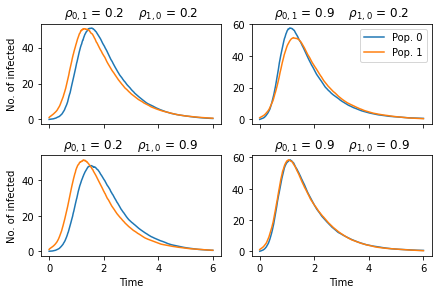

In [111]:
fig, ax = plt.subplots(2, 2, sharex=True)#, figsize=(12, 9))

for i in range(2):
    for j in range(2):
        ax[i, j].plot(time, Y1_mean[i, j, :])
        ax[i, j].plot(time, Y2_mean[i, j, :])
        ax[i, j].set_title(f"$ρ_{{0, 1}}$ = {rhos[i, j]}    $ρ_{{1, 0}}$ = {rhos[j, i]}")
        if (i == 0 and j == 1):
            ax[i, j].legend(["Pop. 0", "Pop. 1"])
        
fig.tight_layout()
ax[0, 0].set_ylabel("No. of infected")
ax[1, 0].set_ylabel("No. of infected")
ax[1, 0].set_xlabel("Time")
ax[1, 1].set_xlabel("Time")
fig.savefig("figures/two_metas.svg")

## 2.2 More Subpopulations

In [113]:
import seaborn as sn

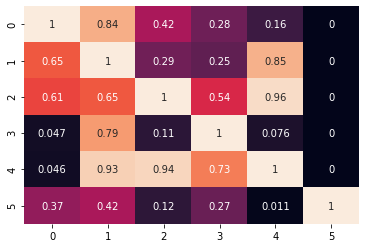

In [136]:
np.random.seed(2212)
# five subpopulations
inits = [[100, 0, 0],
         [100, 0, 0],
         [100, 0, 0],
         [100, 0, 0],
         [100, 0, 0],
         [99, 1, 0]]

n = len(inits) # no. of subpopulations
gamma = n*[1.0]
beta = n*[3.0]

# construct the rho matrix
rho = np.diag(np.ones(len(inits)))
rhos = np.array([0.1, 0.2, 0.4, 0.6, 0.8, 0.9])

for i in range(n):
    for j in range(n):
        if (i != j and j != n-1):
            rho[i, j] = np.random.random()

            
sn.heatmap(rho, annot=True, cbar=False)
plt.savefig("figures/rho_mat.svg")

In [133]:
# perform 100 simulations

mean_pops = [[] for i in range(n)]

time = np.linspace(0, 6, 1000)
Y_means = np.zeros((n, n, len(time)))
for i in range(n):
    rho = np.diag(np.ones(len(inits)))
    rho[:,-1] = rhos[i]
    model = StochasticMetaSIR(inits, gamma, beta, rho)

    ctr = 1
    for k in range(100):
        model.simulate(10)
        if model.time[-1] > 5:
            sol = model.unpack()
            #Ys = [sol[i,:,1] for i in range(n)]

            # interpolate to get all iterations the same length
            for j in range(n):   
                Y_means[i, j, :] += np.interp(time, model.time, sol[j,:,1])

            ctr += 1

        model.__init__(inits, gamma, beta, rho)

    Y_means[i, :, :] /= ctr

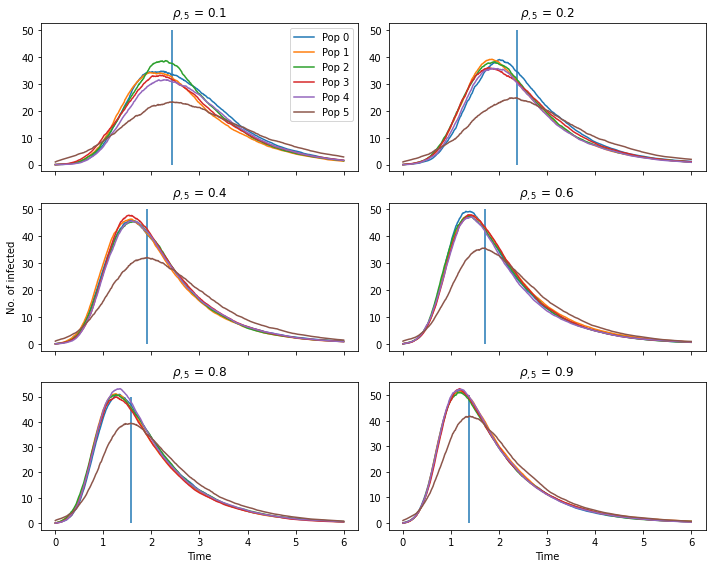

In [140]:
fig, ax = plt.subplots(3, 2, sharex=True, figsize=(10, 8))
ax = ax.flatten()

for i in range(n):
    for j in range(n):
        ax[i].plot(time, Y_means[i, j, :])
    ax[i].set_title(f"$ρ_{{,{n-1}}}$ = {rhos[i]}")
    ax[i].vlines([time[np.argmax(Y_means[i,j,:])]], 0, 50)
    if (i == 0):
        ax[i].legend([f"Pop {i}" for i in range(n)])
    
ax[2].set_ylabel("No. of infected")
ax[4].set_xlabel("Time")
ax[5].set_xlabel("Time")
fig.tight_layout()
#fig.savefig("figures/SixMetas.svg")